In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 105M/105M [00:01<00:00, 68.5MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
class SyntheticDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        class_folders = os.listdir(root_dir)
        class_folders = [c for c in class_folders if os.path.isdir(os.path.join(root_dir, c))]

        label_map = {name: idx for idx, name in enumerate(sorted(class_folders))}

        for class_name in class_folders:
            class_path = os.path.join(root_dir, class_name)
            label = label_map[class_name]

            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(label)

        self.class_names = sorted(class_folders)

        print(f"{root_dir} → {len(self.image_paths)} images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
dataset_path = path  # your dataset root
train_dataset = SyntheticDataset(os.path.join(dataset_path, "train"), transform)
test_dataset = SyntheticDataset(os.path.join(dataset_path, "test"), transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.class_names
print("Classes:", class_names)

/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train → 100000 images
/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/test → 20000 images
Classes: ['FAKE', 'REAL']


In [7]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 → 32

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 → 16

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 → 8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [8]:
def train_model(model, loader, epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in tqdm(loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} Loss: {running_loss/len(loader):.4f}")

In [9]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc

In [11]:
from torch.utils.data import Subset
import numpy as np

def create_balanced_subset(dataset, samples_per_class=2000):
    labels = np.array(dataset.labels)
    indices = []

    for class_id in np.unique(labels):
        class_indices = np.where(labels == class_id)[0]
        selected = np.random.choice(
            class_indices,
            size=min(samples_per_class, len(class_indices)),
            replace=False
        )
        indices.extend(selected)

    np.random.shuffle(indices)
    return Subset(dataset, indices)

In [12]:
train_dataset_full = SyntheticDataset(os.path.join(dataset_path, "train"), transform)

train_dataset = create_balanced_subset(
    train_dataset_full,
    samples_per_class=3000
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("Subset size:", len(train_dataset))

/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train → 100000 images
Subset size: 6000


In [13]:
train_model(model, train_loader, epochs=5)

100%|██████████| 188/188 [01:16<00:00,  2.46it/s]


Epoch 1/5 Loss: 0.2814


100%|██████████| 188/188 [01:22<00:00,  2.27it/s]


Epoch 2/5 Loss: 0.2486


100%|██████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 3/5 Loss: 0.2425


100%|██████████| 188/188 [01:14<00:00,  2.53it/s]


Epoch 4/5 Loss: 0.2242


100%|██████████| 188/188 [01:14<00:00,  2.52it/s]

Epoch 5/5 Loss: 0.1972


In [14]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_full(model, loader):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of FAKE

            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("\n===== CLASSIFICATION METRICS =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    print("\n===== CONTINGENCY TABLE =====")
    print(f"True Negatives : {TN}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Positives : {TP}")

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    print(f"\nAUC Score: {roc_auc:.4f}")

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": roc_auc
    }


===== CLASSIFICATION METRICS =====
Accuracy : 0.9031
Precision: 0.9612
Recall   : 0.8400
F1 Score : 0.8965

===== CONTINGENCY TABLE =====
True Negatives : 9661
False Positives: 339
False Negatives: 1600
True Positives : 8400


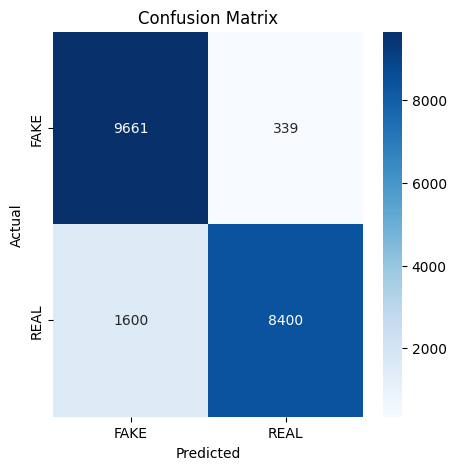


AUC Score: 0.9752


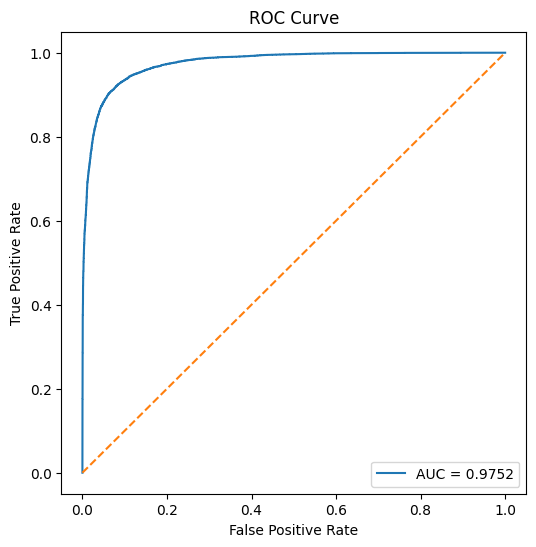

In [15]:
metrics = evaluate_full(model, test_loader)

In [16]:
import cv2
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        # Hook the last conv layer
        target_layer = self.model.features[-3]  # Conv(64→128)

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1)

        loss = output[:, target_class]
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2,3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)

        cam = F.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        cam = cv2.resize(cam, (64,64))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [17]:
def show_gradcam(model, image_tensor, label):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    gradcam = GradCAM(model)
    cam = gradcam.generate(image_tensor)

    # Denormalize
    img = image_tensor.squeeze().detach().cpu().numpy().transpose(1,2,0)
    img = img * np.array([0.5]*3) + np.array([0.5]*3)
    img = np.clip(img, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap / 255.0

    overlay = 0.6 * img + 0.4 * heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

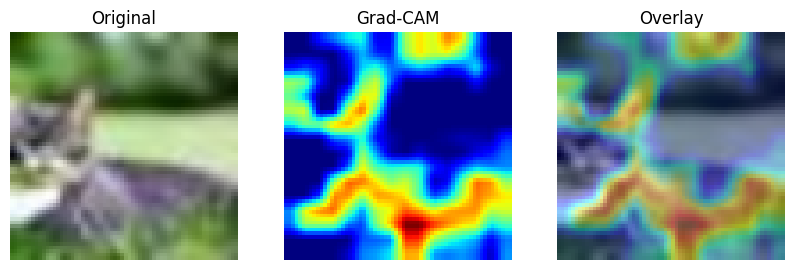

In [19]:
images, labels = next(iter(test_loader))
show_gradcam(model, images[5], labels[5])

PHASE 2

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def get_high_conf_fake_samples(model, loader, threshold=0.95, max_samples=3):
    model.eval()
    selected = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(len(images)):
                if labels[i] == 1 and preds[i] == 1:
                    confidence = probs[i][1].item()
                    if confidence > threshold:
                        selected.append((images[i].unsqueeze(0), labels[i].unsqueeze(0)))
                        print(f"Selected sample with FAKE confidence: {confidence:.4f}")
                        if len(selected) >= max_samples:
                            return selected
    return selected

In [22]:
samples = get_high_conf_fake_samples(model, test_loader)

Selected sample with FAKE confidence: 0.9811
Selected sample with FAKE confidence: 0.9981
Selected sample with FAKE confidence: 0.9965


In [23]:
image, label = samples[0]

with torch.no_grad():
    output = model(image)
    probs = F.softmax(output, dim=1)

print("Original Prediction:", torch.argmax(probs, dim=1).item())
print("Real Confidence:", probs[0][0].item())
print("Fake Confidence:", probs[0][1].item())

Original Prediction: 1
Real Confidence: 0.018859658390283585
Fake Confidence: 0.9811403751373291


In [24]:
def iterative_fgsm(model, image, label, epsilon=0.15, alpha=0.02, steps=15):
    perturbed = image.clone().detach().to(device)
    original = image.clone().detach().to(device)
    label = label.to(device)

    trajectory = []

    for step in range(steps):
        perturbed.requires_grad = True

        outputs = model(perturbed)
        probs = F.softmax(outputs, dim=1)

        fake_conf = probs[0][1].item()
        real_conf = probs[0][0].item()
        pred = torch.argmax(probs, dim=1).item()

        trajectory.append((step, fake_conf, real_conf, pred))

        loss = F.cross_entropy(outputs, label)

        model.zero_grad()
        loss.backward()

        grad_sign = perturbed.grad.data.sign()

        perturbed = perturbed + alpha * grad_sign

        # Keep perturbation within epsilon-ball
        eta = torch.clamp(perturbed - original, min=-epsilon, max=epsilon)
        perturbed = torch.clamp(original + eta, -1, 1).detach()

    return perturbed, trajectory

In [25]:
adv_image, trajectory = iterative_fgsm(
    model,
    image,
    label,
    epsilon=0.15,
    alpha=0.02,
    steps=20
)

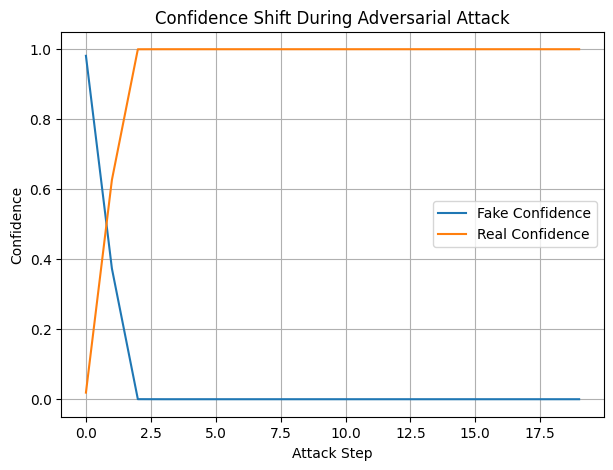

In [26]:
steps = [t[0] for t in trajectory]
fake_conf = [t[1] for t in trajectory]
real_conf = [t[2] for t in trajectory]

plt.figure(figsize=(7,5))
plt.plot(steps, fake_conf, label="Fake Confidence")
plt.plot(steps, real_conf, label="Real Confidence")
plt.xlabel("Attack Step")
plt.ylabel("Confidence")
plt.title("Confidence Shift During Adversarial Attack")
plt.legend()
plt.grid()
plt.show()

In [27]:
with torch.no_grad():
    final_output = model(adv_image)
    final_probs = F.softmax(final_output, dim=1)

print("Final Prediction:", torch.argmax(final_probs, dim=1).item())
print("Final Real Confidence:", final_probs[0][0].item())
print("Final Fake Confidence:", final_probs[0][1].item())

Final Prediction: 0
Final Real Confidence: 1.0
Final Fake Confidence: 0.0


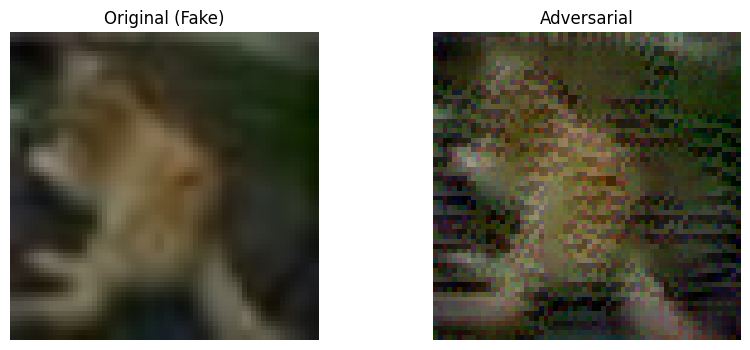

In [28]:
def denorm(x):
    x = x.cpu().numpy().transpose(1,2,0)
    x = x * 0.5 + 0.5
    return np.clip(x, 0, 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(denorm(image[0]))
plt.title("Original (Fake)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(denorm(adv_image[0]))
plt.title("Adversarial")
plt.axis("off")

plt.show()

In [29]:
perturbation = (adv_image - image).abs().mean().item()
print("Average perturbation magnitude:", perturbation)

Average perturbation magnitude: 0.10378394275903702


In [30]:
l2_norm = torch.norm((adv_image - image).view(-1)).item()
print("L2 perturbation norm:", l2_norm)

L2 perturbation norm: 12.904398918151855


In [31]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image, class_idx=None):
        self.model.zero_grad()

        output = self.model(input_image)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        loss = output[:, class_idx]
        loss.backward()

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * activations, dim=1)
        cam = torch.relu(cam)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [32]:
target_layer = model.features[8]
grad_cam = GradCAM(model, target_layer)

In [33]:
original_cam = grad_cam.generate(image)
adv_cam = grad_cam.generate(adv_image)

In [34]:
import cv2

original_cam = cv2.resize(original_cam, (64, 64))
adv_cam = cv2.resize(adv_cam, (64, 64))

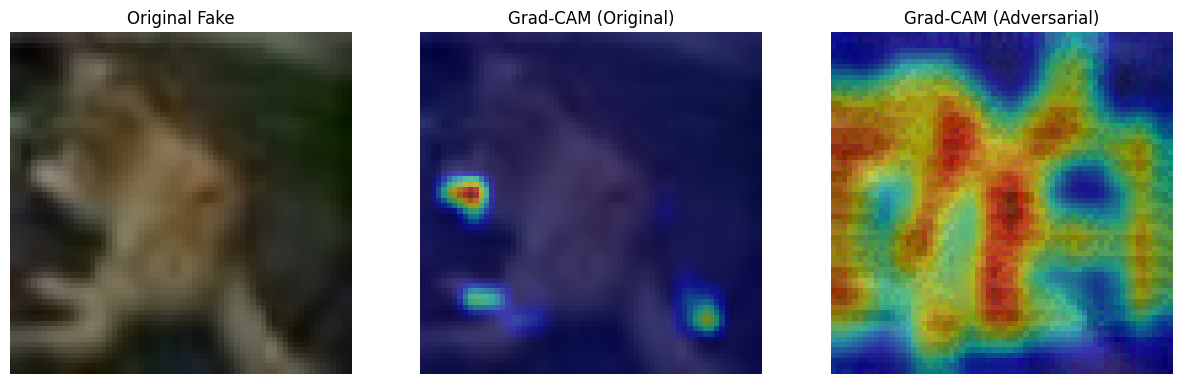

In [35]:
def denorm(x):
    x = x.cpu().numpy().transpose(1,2,0)
    x = x * 0.5 + 0.5
    return np.clip(x, 0, 1)

orig_img = denorm(image[0])
adv_img = denorm(adv_image[0])

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(orig_img)
plt.title("Original Fake")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(orig_img)
plt.imshow(original_cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM (Original)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(adv_img)
plt.imshow(adv_cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM (Adversarial)")
plt.axis("off")

plt.show()

**PHASE 3**

In [36]:
def fgsm_attack_train(model, images, labels, epsilon=0.05):
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    images.requires_grad = True

    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed = images + epsilon * images.grad.sign()
    perturbed = torch.clamp(perturbed, -1, 1)

    return perturbed.detach()

In [45]:
def fgsm_attack_eval(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    images.requires_grad = True

    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed = images + epsilon * images.grad.sign()
    perturbed = torch.clamp(perturbed, -1, 1)

    return perturbed.detach()

from sklearn.metrics import accuracy_score

def evaluate_under_attack(model, loader, epsilon):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        perturbed_images = fgsm_attack_eval(model, images, labels, epsilon)

        with torch.no_grad():
            outputs = model(perturbed_images)
            preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return accuracy_score(all_labels, all_preds)

In [39]:
def train_adversarial(model, train_loader, optimizer, epochs=3, epsilon=0.05):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # ---- Clean loss ----
            outputs_clean = model(images)
            loss_clean = F.cross_entropy(outputs_clean, labels)

            # ---- Generate adversarial examples ----
            adv_images = fgsm_attack_train(model, images, labels, epsilon)

            outputs_adv = model(adv_images)
            loss_adv = F.cross_entropy(outputs_adv, labels)

            # ---- Combined loss ----
            loss = 0.5 * loss_clean + 0.5 * loss_adv

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_adversarial(
    model,
    train_loader,
    optimizer,
    epochs=3,
    epsilon=0.05
)

Epoch [1/3] Loss: 0.5448
Epoch [2/3] Loss: 0.5226
Epoch [3/3] Loss: 0.5178


Accuracy: 0.8937
Precision: 0.8841725214676034
Recall: 0.9061
F1: 0.8950019755037535


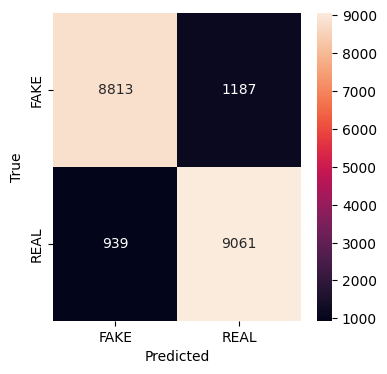

0.8937

In [41]:
evaluate_model(model, test_loader)

In [46]:
epsilons = [0, 0.05, 0.1, 0.15]

for eps in epsilons:
    acc = evaluate_under_attack(model, test_loader, eps)
    print(f"Epsilon {eps:.2f} -> Accuracy: {acc:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epsilon 0.00 -> Accuracy: 0.8937


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epsilon 0.05 -> Accuracy: 0.5042


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epsilon 0.10 -> Accuracy: 0.3694


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epsilon 0.15 -> Accuracy: 0.4743


**# Stronger FGSM (Same Function, Higher ε)**

In [47]:
def fgsm_attack_train(model, images, labels, epsilon=0.1):
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed = images + epsilon * images.grad.sign()
    perturbed = torch.clamp(perturbed, -1, 1)

    return perturbed.detach()

In [48]:
def train_stronger_adversarial(model, train_loader, optimizer, epochs=5, epsilon=0.1):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Clean forward
            outputs_clean = model(images)
            loss_clean = F.cross_entropy(outputs_clean, labels)

            # Adversarial examples
            adv_images = fgsm_attack_train(model, images, labels, epsilon)
            outputs_adv = model(adv_images)
            loss_adv = F.cross_entropy(outputs_adv, labels)

            # Emphasize adversarial robustness
            loss = 0.4 * loss_clean + 0.6 * loss_adv

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

train_stronger_adversarial(
    model,
    train_loader,
    optimizer,
    epochs=5,
    epsilon=0.1
)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch [1/5] Loss: 0.5925
Epoch [2/5] Loss: 0.5800
Epoch [3/5] Loss: 0.5670
Epoch [4/5] Loss: 0.5570
Epoch [5/5] Loss: 0.5475


In [50]:
epsilons = [0, 0.05, 0.1, 0.15]

for eps in epsilons:
    acc = evaluate_under_attack(model, test_loader, eps)
    print(f"Epsilon {eps:.2f} -> Accuracy: {acc:.4f}")

Epsilon 0.00 -> Accuracy: 0.8739


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epsilon 0.05 -> Accuracy: 0.5756


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epsilon 0.10 -> Accuracy: 0.4870


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epsilon 0.15 -> Accuracy: 0.4914
